# Import Dependencies
- Import common libraries for data analysis, visualization, and modeling.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, log_loss
from xgboost import XGBClassifier
from sklearn.tree import plot_tree

# Data Loading and Preview
- Load `sf-crime/train.csv`
- Preview the first rows and summarize missing values

In [3]:

df = pd.read_csv('sf-crime/train.csv')

# A. Data Understanding and Preprocessing

# 1. Check the first few rows of the dataset
print('First few rows:')
print(df.head())

# 2. Check for missing values
print('Missing values:')
print(df.isnull().sum())

First few rows:
                 Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.8008

# Data Cleaning
- Parse and clean the date column (drop unparseable records)
- Remove duplicate rows
- Filter out invalid coordinates (keep within San Francisco bounds)
- Print dataset shape after cleaning

In [4]:
# 3. Basic structure and types
print('Shape:', df.shape)
print(df.dtypes)

# 4. Parse date column and handle invalid values
date_col = 'Dates' if 'Dates' in df.columns else None
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    invalid_dates = df[date_col].isna().sum()
    if invalid_dates:
        print(f'Invalid dates: {invalid_dates} — dropping them')
        df = df[df[date_col].notna()].copy()
else:
    print('No date column found')

# 5. Drop exact duplicates
dup_count = df.duplicated().sum()
print('Duplicate rows:', dup_count)
if dup_count:
    df = df.drop_duplicates().copy()

# 6. Sanity check coordinates (keep plausible SF bounds)
if {'X','Y'}.issubset(df.columns):
    before = len(df)
    df = df[df['Y'].between(37.0, 38.0) & df['X'].between(-123.0, -121.0)].copy()
    print(f'Removed {before - len(df)} rows outside SF bounds')

print('Cleaned shape:', df.shape)


Shape: (878049, 9)
Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object
Duplicate rows: 2323
Removed 67 rows outside SF bounds
Cleaned shape: (875659, 9)


# Feature Engineering and Encoding
- Construct Arrest_Indicator, Year/Month/Day/Hour, Incident_Quarter
- One-hot encode DayOfWeek, PdDistrict, Resolution; label-encode Category if present
- Example filters: create subsets by year (e.g., 2015) and district (e.g., Mission)

In [5]:
# 7. Derived variables: Arrest Indicator, Incident Quarter, calendar parts

if 'Resolution' in df.columns:

    df['Arrest_Indicator'] = df['Resolution'].str.contains('ARREST', case=False, na=False).astype(int)


if 'Dates' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Dates']):

    df['Year'] = df['Dates'].dt.year

    df['Month'] = df['Dates'].dt.month

    df['Day'] = df['Dates'].dt.day

    df['Hour'] = df['Dates'].dt.hour

    df['Incident_Quarter'] = df['Dates'].dt.to_period('Q').astype(str)


# 8. Encode categorical variables (one-hot)

categorical_cols = [c for c in ['DayOfWeek','PdDistrict','Resolution'] if c in df.columns]

for c in categorical_cols:

    df[c] = df[c].astype('category')


df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


# Optionally encode target for modeling later

if 'Category' in df_encoded.columns:

    le = LabelEncoder()

    df_encoded['Category_encoded'] = le.fit_transform(df_encoded['Category'])


print('Encoded shape:', df_encoded.shape)

display(df_encoded.head())


# 9. Optional filter examples (by year and district)

if 'Year' in df_encoded.columns:

    df_2015 = df_encoded[df_encoded['Year'] == 2015].copy()

else:

    df_2015 = df_encoded.copy()


if 'PdDistrict' in df.columns:

    mission_idx = df['PdDistrict'] == 'MISSION'

    df_mission = df_encoded[mission_idx].copy()

else:

    df_mission = df_encoded.copy()


print('Rows in 2015:', len(df_2015))

print('Rows in Mission district:', len(df_mission))



Encoded shape: (875659, 44)


,Dates,Category,Descript,Address,X,Y,Arrest_Indicator,Year,Month,Day,...,Resolution_JUVENILE CITED,Resolution_JUVENILE DIVERTED,Resolution_LOCATED,Resolution_NONE,Resolution_NOT PROSECUTED,Resolution_PROSECUTED BY OUTSIDE AGENCY,Resolution_PROSECUTED FOR LESSER OFFENSE,Resolution_PSYCHOPATHIC CASE,Resolution_UNFOUNDED,Category_encoded
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,OAK ST / LAGUNA ST,-122.425892,37.774599,1,2015,5,13,...,False,False,False,False,False,False,False,False,False,37
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,OAK ST / LAGUNA ST,-122.425892,37.774599,1,2015,5,13,...,False,False,False,False,False,False,False,False,False,21
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,VANNESS AV / GREENWICH ST,-122.424363,37.800414,1,2015,5,13,...,False,False,False,False,False,False,False,False,False,21
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,1500 Block of LOMBARD ST,-122.426995,37.800873,0,2015,5,13,...,False,False,False,True,False,False,False,False,False,16
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,100 Block of BRODERICK ST,-122.438738,37.771541,0,2015,5,13,...,False,False,False,True,False,False,False,False,False,16


Rows in 2015: 27522
Rows in Mission district: 119722


# Modeling and Evaluation
- Select features and build train/test sets
- Compare multiple algorithms (Logistic Regression, Decision Tree, Random Forest; include XGBoost if available)
- Use cross-validation with Accuracy and Macro-F1
- Report test Accuracy and Macro-F1, and plot the confusion matrix
- Perform hyperparameter tuning (GridSearchCV)
- Visualize important features and model structure/relationships

In [6]:

# 10. Feature selection for modeling the Category
# Target
if 'Category_encoded' not in df_encoded.columns:
    raise ValueError('Target `Category_encoded` not found; ensure earlier cell ran successfully.')

y = df_encoded['Category_encoded']

# We'll avoid leakage by excluding Resolution-derived columns and Arrest_Indicator.
# Also avoid high-cardinality Address_* dummies in features to keep model tractable.
# Keep time parts, coordinates, DayOfWeek_*, PdDistrict_*
numeric_keep = [c for c in ['Year','Month','Day','Hour','X','Y'] if c in df_encoded.columns]
keep_prefixes = ('DayOfWeek_', 'PdDistrict_')

X_cols = []
for c in df_encoded.columns:
    if c in numeric_keep:
        X_cols.append(c)
    elif c.startswith(keep_prefixes):
        X_cols.append(c)

# Sanity: Ensure we have features
if not X_cols:
    raise ValueError('No features selected. Check earlier encoding steps.')

X = df_encoded[X_cols].copy()
print('Selected features:', len(X_cols))
print('Sample features:', X_cols[:10])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train/Test shapes:', X_train.shape, X_test.shape)


Selected features: 21
Sample features: ['X', 'Y', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek_Monday', 'DayOfWeek_Saturday', 'DayOfWeek_Sunday', 'DayOfWeek_Thursday']
Train/Test shapes: (700527, 21) (175132, 21)


In [7]:

# 11. Cross-validation comparison of baseline models

models = {
    'Logistic': LogisticRegression(max_iter=1000, n_jobs=1),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=1)
}

# Optionally include XGBoost if available
try:
    models['XGBoost'] = XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8,
        objective='multi:softprob', eval_metric='mlogloss', tree_method='hist',device='cuda', n_jobs=1, random_state=42
    )
except Exception as e:
    print('XGBoost not available, skipping.')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'acc':'accuracy','f1_macro':'f1_macro','logloss':'neg_log_loss'}

cv_results = {}
for name, clf in models.items():
    res = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=1, return_train_score=False)
    cv_results[name] = {k: (v.mean(), v.std()) for k, v in res.items() if k.startswith('test_')}

print('CV (5-fold) results:')
for name, res in cv_results.items():
    logloss_mean = -res['test_logloss'][0]
    logloss_std = res['test_logloss'][1]
    print(f"{name:12s} | Acc: {res['test_acc'][0]:.3f} ± {res['test_acc'][1]:.3f} | F1_macro: {res['test_f1_macro'][0]:.3f} ± {res['test_f1_macro'][1]:.3f} | LogLoss: {logloss_mean:.3f} ± {logloss_std:.3f}")


d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

CV (5-fold) results:
Logistic     | Acc: 0.200 ± 0.001 | F1_macro: 0.011 ± 0.001 | LogLoss: 2.669 ± 0.001
DecisionTree | Acc: 0.237 ± 0.000 | F1_macro: 0.112 ± 0.002 | LogLoss: 26.641 ± 0.013
RandomForest | Acc: 0.304 ± 0.000 | F1_macro: 0.101 ± 0.001 | LogLoss: 2.393 ± 0.003
XGBoost      | Acc: 0.281 ± 0.001 | F1_macro: 0.090 ± 0.002 | LogLoss: 2.387 ± 0.002


d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic -> Test Accuracy: 0.202, Macro-F1: 0.013, LogLoss: 2.670
DecisionTree -> Test Accuracy: 0.237, Macro-F1: 0.112, LogLoss: 26.627
RandomForest -> Test Accuracy: 0.303, Macro-F1: 0.102, LogLoss: 2.391
XGBoost -> Test Accuracy: 0.282, Macro-F1: 0.091, LogLoss: 2.387
Best (by Macro-F1): DecisionTree


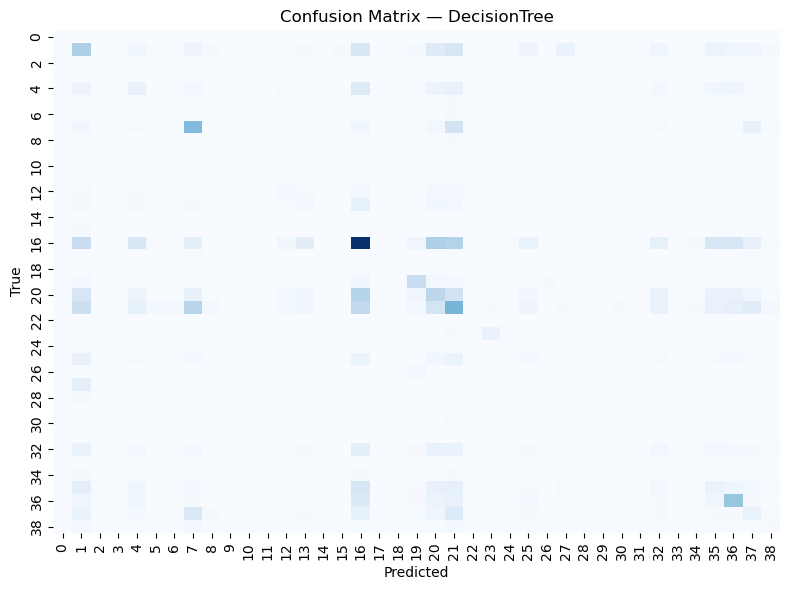

Classification report for best model:
              precision    recall  f1-score   support

           0       0.02      0.03      0.03       302
           1       0.20      0.25      0.22     15362
           2       0.00      0.00      0.00        81
           3       0.00      0.00      0.00        58
           4       0.11      0.11      0.11      7320
           5       0.02      0.03      0.03       862
           6       0.02      0.03      0.03       454
           7       0.34      0.48      0.40     10784
           8       0.00      0.01      0.01       855
           9       0.01      0.01      0.01       233
          10       0.00      0.00      0.00        51
          11       0.04      0.04      0.04        98
          12       0.10      0.11      0.10      2118
          13       0.06      0.08      0.07      3327
          14       0.10      0.10      0.10        29
          15       0.04      0.04      0.04       468
          16       0.37      0.33      0.35

d:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:

# 12. Train/test evaluation and confusion matrix

fit_results = {}
for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average='macro')
    ll = log_loss(y_test, y_proba, labels=clf.classes_)
    fit_results[name] = {'acc': acc, 'f1_macro': f1m, 'logloss': ll, 'y_pred': y_pred, 'y_proba': y_proba}
    print(f"{name} -> Test Accuracy: {acc:.3f}, Macro-F1: {f1m:.3f}, LogLoss: {ll:.3f}")

# Pick best by Macro-F1
best_name = max(fit_results, key=lambda k: fit_results[k]['f1_macro'])
print(f"Best (by Macro-F1): {best_name}")

y_pred_best = fit_results[best_name]['y_pred']
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix — {best_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

print('Classification report for best model:')
print(classification_report(y_test, y_pred_best))



In [9]:

# 13. Hyperparameter tuning (GridSearchCV)

search_spaces = {
    'Logistic': (LogisticRegression(max_iter=1000),
                 {'C':[0.1,1,3], 'penalty':['l2'], 'solver':['lbfgs'] }),
    'DecisionTree': (DecisionTreeClassifier(random_state=42),
                     {'max_depth':[None,10,20], 'min_samples_split':[2,10,50]}),
    'RandomForest': (RandomForestClassifier(random_state=42, n_jobs=-1),
                     {'n_estimators':[200,400], 'max_depth':[None,20], 'min_samples_split':[2,10]})
}

best_estimators = {}
for name, (est, grid) in search_spaces.items():
    print(f"Tuning {name} ...")
    gs = GridSearchCV(est, grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=0)
    gs.fit(X_train, y_train)
    print('Best params:', gs.best_params_)
    print('Best CV f1_macro:', gs.best_score_)
    best_estimators[name] = gs.best_estimator_

# Evaluate tuned models
for name, est in best_estimators.items():
    y_pred = est.predict(X_test)
    y_proba = est.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average='macro')
    ll = log_loss(y_test, y_proba, labels=est.classes_)
    print(f"{name} (tuned) -> Test Accuracy: {acc:.3f}, Macro-F1: {f1m:.3f}, LogLoss: {ll:.3f}")


Tuning Logistic ...


d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV f1_macro: 0.01157685883554818
Tuning DecisionTree ...
Best params: {'max_depth': None, 'min_samples_split': 2}
Best CV f1_macro: 0.10103013333525018
Tuning RandomForest ...


MemoryError: Unable to allocate 3.56 MiB for an array with shape (467018,) and data type int64

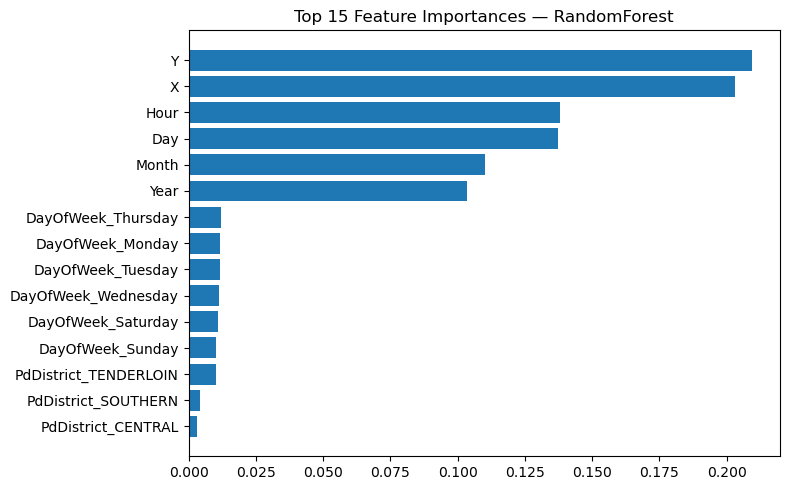

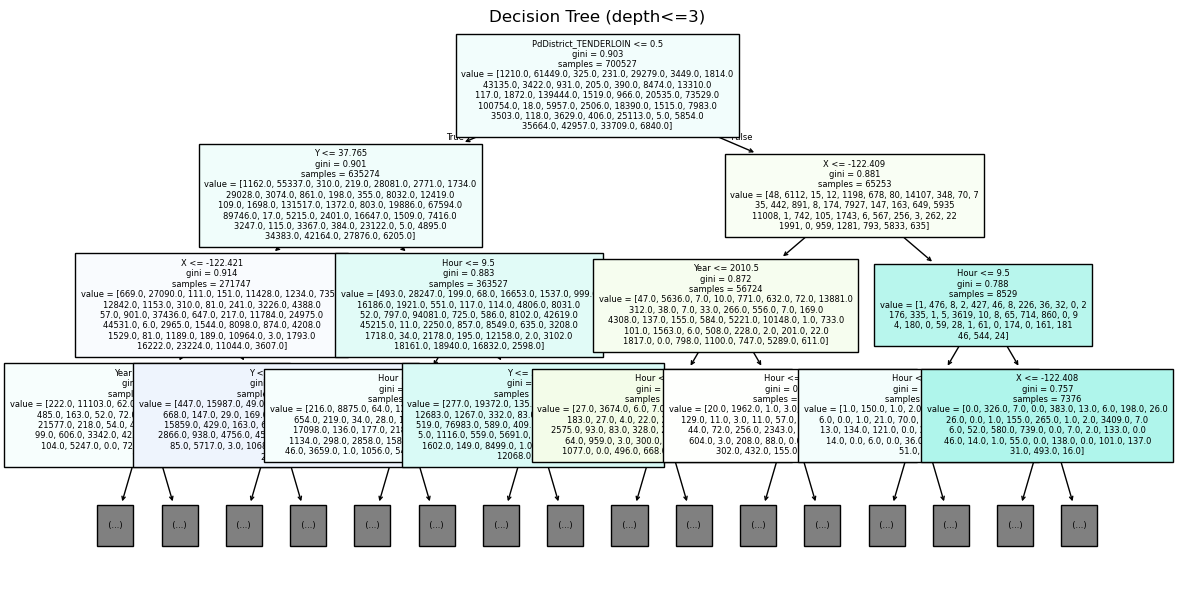

In [10]:

# 14. Visualizations: feature importance and tree structure (if applicable)

# Feature importances for RandomForest (tuned if available)
rf = best_estimators.get('RandomForest', models.get('RandomForest'))
if hasattr(rf, 'feature_importances_'):
    importances = rf.feature_importances_
    idx = np.argsort(importances)[::-1][:15]
    plt.figure(figsize=(8,5))
    plt.barh(range(len(idx)), importances[idx][::-1])
    plt.yticks(range(len(idx)), [X.columns[i] for i in idx][::-1])
    plt.title('Top 15 Feature Importances — RandomForest')
    plt.tight_layout()
    plt.show()

# Plot a shallow Decision Tree for interpretability
clf_tree = best_estimators.get('DecisionTree', DecisionTreeClassifier(max_depth=3, random_state=42))
if not hasattr(clf_tree, 'tree_'):
    clf_tree.fit(X_train, y_train)
plt.figure(figsize=(12,6))
plot_tree(clf_tree, feature_names=X.columns.tolist(), max_depth=3, filled=True, fontsize=6)
plt.title('Decision Tree (depth<=3)')
plt.tight_layout()
plt.show()


# Interpretation and Insights
- Highlight feature influence on predicted crime type
- Explore bias motives (if present/derivable) linked to offense categories
- Look at temporal patterns to inform proactive interventions


In [11]:
# 15. Which features most influence predicted crime type?
rf_fit = best_estimators.get('RandomForest', models.get('RandomForest'))
log_fit = best_estimators.get('Logistic', models.get('Logistic'))

if hasattr(rf_fit, 'feature_importances_'):
    fi = pd.Series(rf_fit.feature_importances_, index=X.columns)
    top_rf = fi.sort_values(ascending=False).head(12)
    print('Top features by RandomForest importance:')
    display(top_rf.to_frame('importance'))
else:
    top_rf = pd.Series(dtype=float)
    print('RandomForest importances not available.')

if hasattr(log_fit, 'coef_') and log_fit.coef_.size:
    coef_strength = pd.Series(np.abs(log_fit.coef_).mean(axis=0), index=X.columns)
    top_log = coef_strength.sort_values(ascending=False).head(12)
    print('\nMost influential logistic regression features (avg |coef| across classes):')
    display(top_log.to_frame('avg_abs_coef'))
else:
    try:
        log_fit = log_fit.fit(X_train, y_train)
        coef_strength = pd.Series(np.abs(log_fit.coef_).mean(axis=0), index=X.columns)
        top_log = coef_strength.sort_values(ascending=False).head(12)
        print('\nMost influential logistic regression features (avg |coef| across classes):')
        display(top_log.to_frame('avg_abs_coef'))
    except Exception as e:
        top_log = pd.Series(dtype=float)
        print('Logistic coefficients unavailable:', e)

# Consolidated view for quick briefing
if not top_rf.empty or not top_log.empty:
    influence_summary = pd.concat({
        'RandomForest': top_rf,
        'Logistic_avg_abs_coef': top_log
    }, axis=1)
    display(influence_summary)
else:
    print('No feature influence metrics to summarize.')


Top features by RandomForest importance:


,importance
Y,0.209382
X,0.203238
Hour,0.137902
Day,0.137450
Month,0.110072
Year,0.103649
DayOfWeek_Thursday,0.011964
DayOfWeek_Monday,0.011750
DayOfWeek_Tuesday,0.011715
DayOfWeek_Wednesday,0.011255



Most influential logistic regression features (avg |coef| across classes):


,avg_abs_coef
Hour,0.009353
PdDistrict_TENDERLOIN,0.003159
PdDistrict_SOUTHERN,0.002665
Month,0.002456
Day,0.002205
PdDistrict_INGLESIDE,0.001982
PdDistrict_CENTRAL,0.001976
PdDistrict_NORTHERN,0.001640
X,0.001548
PdDistrict_MISSION,0.001502


,RandomForest,Logistic_avg_abs_coef
Y,0.209382,NaN
X,0.203238,0.001548
Hour,0.137902,0.009353
Day,0.137450,0.002205
Month,0.110072,0.002456
Year,0.103649,NaN
DayOfWeek_Thursday,0.011964,NaN
DayOfWeek_Monday,0.011750,NaN
DayOfWeek_Tuesday,0.011715,NaN
DayOfWeek_Wednesday,0.011255,NaN


In [12]:
# 16. Bias motive (if available) vs offense category
import re
from scipy.stats import chi2_contingency

bias_candidates = [c for c in df.columns if 'bias' in c.lower()]
df_bias = None

if bias_candidates:
    bias_col = bias_candidates[0]
    df_bias = df.copy()
    df_bias['BiasMotive'] = df[bias_col].fillna('Unspecified')
    print(f'Bias motive source: {bias_col}')
elif 'Descript' in df.columns:
    bias_keywords = {
        'Racial/Ethnic': ['RACIAL', 'RACIST', 'BLACK', 'AFRICAN', 'ASIAN', 'CHINESE', 'KOREAN', 'VIETNAMESE', 'LATINO', 'HISPANIC', 'MEXICAN'],
        'Religious': ['JEW', 'MUSLIM', 'ISLAM', 'CHRISTIAN', 'CATHOLIC', 'BUDDHIST'],
        'Gender/Sexuality': ['GAY', 'LGBT', 'LESBIAN', 'HOMOPHOB', 'TRANS'],
        'Disability': ['DISABILITY', 'DISABLED']
    }

    def infer_bias(text: str) -> str:
        if pd.isna(text):
            return 'Unspecified'
        t = str(text).upper()
        for motive, keywords in bias_keywords.items():
            if any(k in t for k in keywords):
                return motive
        return 'Unspecified'

    df_bias = df.copy()
    df_bias['BiasMotive'] = df_bias['Descript'].apply(infer_bias)
    print('Bias motive derived from `Descript` keywords (proxy).')
else:
    print('No descriptive text available to infer bias motives; skipping cross-analysis.')

if df_bias is not None:
    bias_counts = df_bias['BiasMotive'].value_counts()
    print('\nBias motive counts (top 10):')
    display(bias_counts.head(10).to_frame('count'))

    filtered_bias = df_bias[df_bias['BiasMotive'] != 'Unspecified']
    if filtered_bias.empty:
        print('No explicit/inferred bias motives found — typical for general SF crime data.')
    else:
        top_categories = df['Category'].value_counts().head(8).index if 'Category' in df.columns else None
        cross = pd.crosstab(filtered_bias['BiasMotive'], filtered_bias['Category'])
        if top_categories is not None:
            cross = cross.loc[:, [c for c in top_categories if c in cross.columns]]
        if cross.empty:
            print('No overlap between bias motives and categories after filtering.')
        else:
            cross_pct = cross.div(cross.sum(axis=1), axis=0)
            print('\nBias motive -> offense category (row-normalized):')
            display(cross_pct)

            chi2, p, dof, exp = chi2_contingency(cross)
            cramers_v = np.sqrt(chi2 / (cross.values.sum() * (min(cross.shape) - 1))) if min(cross.shape) > 1 else np.nan
            print(f'Cramers V association: {cramers_v:.3f} (p={p:.3e})')

            top_pairs = cross_pct.stack().sort_values(ascending=False).head(8)
            print('\nTop Bias motive / Category combinations:')
            display(top_pairs)


Bias motive derived from `Descript` keywords (proxy).

Bias motive counts (top 10):


,count
BiasMotive,
Unspecified,874131
Gender/Sexuality,1482
Disability,46



Bias motive -> offense category (row-normalized):


Category,OTHER OFFENSES,DRUG/NARCOTIC,VANDALISM
BiasMotive,,,
Disability,1.000000,0.000000,0.00000
Gender/Sexuality,0.295265,0.664345,0.04039


Cramers V association: 0.263 (p=6.358e-23)

Top Bias motive / Category combinations:


BiasMotive        Category      
Disability        OTHER OFFENSES    1.000000
Gender/Sexuality  DRUG/NARCOTIC     0.664345
                  OTHER OFFENSES    0.295265
                  VANDALISM         0.040390
Disability        DRUG/NARCOTIC     0.000000
                  VANDALISM         0.000000
dtype: float64

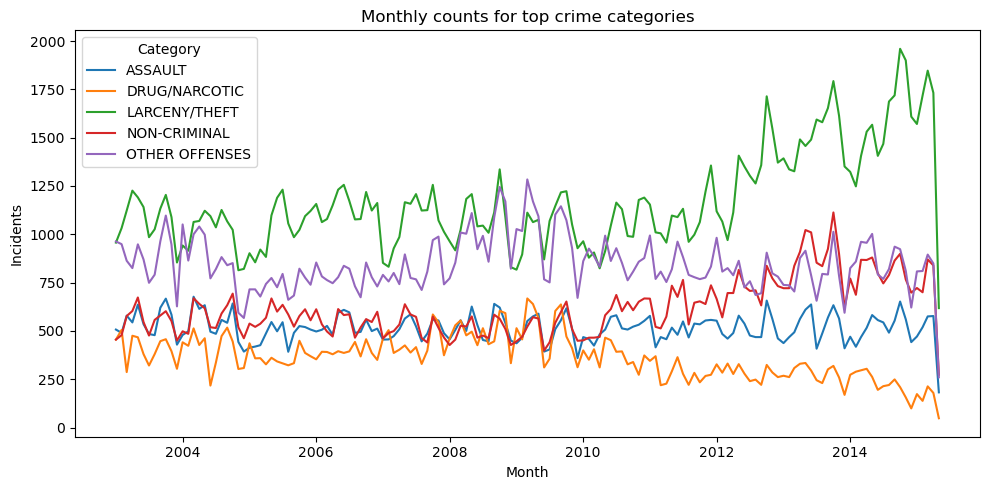

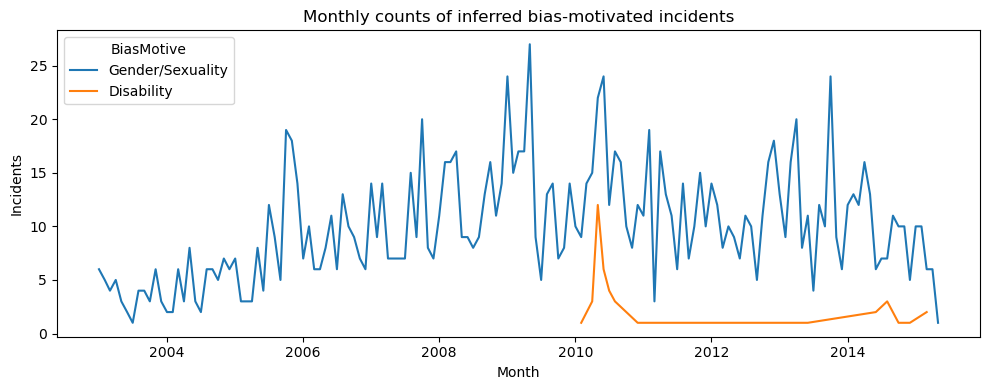

In [13]:
# 17. Temporal trends (monthly/quarterly) for categories and bias motives
if 'Dates' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Dates']):
    df_time = df.copy()
    df_time['MonthStart'] = df_time['Dates'].dt.to_period('M').dt.to_timestamp()
    top_cats = df_time['Category'].value_counts().head(5).index if 'Category' in df_time.columns else []
    if len(top_cats):
        monthly_cat = df_time[df_time['Category'].isin(top_cats)].groupby(['MonthStart','Category']).size().reset_index(name='count')
        plt.figure(figsize=(10,5))
        sns.lineplot(data=monthly_cat, x='MonthStart', y='count', hue='Category')
        plt.title('Monthly counts for top crime categories')
        plt.xlabel('Month')
        plt.ylabel('Incidents')
        plt.tight_layout()
        plt.show()
    else:
        print('Category column missing; skipping category trend lines.')

    if df_bias is not None:
        df_time_bias = df_bias.copy()
        df_time_bias = df_time_bias[df_time_bias['BiasMotive'] != 'Unspecified']
        if not df_time_bias.empty:
            df_time_bias['MonthStart'] = df_time_bias['Dates'].dt.to_period('M').dt.to_timestamp()
            monthly_bias = df_time_bias.groupby(['MonthStart','BiasMotive']).size().reset_index(name='count')
            plt.figure(figsize=(10,4))
            sns.lineplot(data=monthly_bias, x='MonthStart', y='count', hue='BiasMotive')
            plt.title('Monthly counts of inferred bias-motivated incidents')
            plt.xlabel('Month')
            plt.ylabel('Incidents')
            plt.tight_layout()
            plt.show()
        else:
            print('No inferred bias-motivated incidents to plot.')
else:
    print('Date column missing or not parsed; temporal analysis skipped.')


In [14]:
# 18. Actionable recommendations (data-driven bullets)
recommendations = []

if 'PdDistrict' in df.columns and len(df):
    district_counts = df['PdDistrict'].value_counts().head(3)
    share = district_counts.sum() / len(df)
    recommendations.append(f"Concentrate multi-lingual awareness campaigns and foot patrols in {', '.join(district_counts.index)} (cover {share:.1%} of incidents).")

if 'Hour' in df.columns:
    peak_hours = df['Hour'].value_counts().nlargest(3).index.tolist()
    recommendations.append(f"Schedule community education and visible policing around peak hours {peak_hours} to deter high-volume incidents.")

if df_bias is not None and 'BiasMotive' in df_bias.columns:
    top_bias = df_bias[df_bias['BiasMotive'] != 'Unspecified']['BiasMotive'].value_counts().head(3)
    if not top_bias.empty:
        bias_targets = ', '.join(top_bias.index)
        recommendations.append(f"Co-design outreach with community leaders to address bias motives: {bias_targets}.")
    else:
        recommendations.append('No explicit bias motives detected; prioritize improving data capture on bias indicators in incident reports.')
else:
    recommendations.append('Bias motive data absent; recommend adding fields/training for bias identification to support targeted interventions.')

if 'Category' in df.columns and not df['Category'].empty:
    top_cat = df['Category'].value_counts().idxmax()
    recommendations.append(f"Allocate investigative resources to the leading offense category ({top_cat}) and consider dedicated task-force time blocks.")

for rec in recommendations:
    print('-', rec)


- Concentrate multi-lingual awareness campaigns and foot patrols in SOUTHERN, MISSION, NORTHERN (cover 43.5% of incidents).
- Schedule community education and visible policing around peak hours [18, 17, 12] to deter high-volume incidents.
- Co-design outreach with community leaders to address bias motives: Gender/Sexuality, Disability.
- Allocate investigative resources to the leading offense category (LARCENY/THEFT) and consider dedicated task-force time blocks.
